In [8]:
import os

In [9]:
RECURSIVE_PREDICTIONS_DIR = os.path.join("scripts", "forecasting", "resultados-recursive-prediction", "predicoes")
LSTM_PREDICTIONS_DIR = os.path.join("results", "bi-lstm", "forecast")

In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from glob import glob

def calculate_metrics(true_vals, pred_vals):
    rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
    
    mean_true = np.mean(true_vals)
    max_true = np.max(true_vals)
    min_true = np.min(true_vals)

    nrmse_mean = rmse / mean_true if mean_true != 0 else np.nan
    nrmse_range = rmse / (max_true - min_true) if (max_true - min_true) != 0 else np.nan

    return rmse, nrmse_mean, nrmse_range

def process_directory(input_dir, output_file="metrics_summary2.csv"):
    results = []

    for filepath in glob(os.path.join(input_dir, "*.csv")):
        try:
            df = pd.read_csv(filepath)
            if {'Test', 'Prediction'}.issubset(df.columns):
                rmse, nrmse_mean, nrmse_range = calculate_metrics(
                    df['Test'].values,
                    df['Prediction'].values
                )
                results.append({
                    "filename": os.path.basename(filepath),
                    "rmse": rmse,
                    "nrmse_mean": nrmse_mean,
                    "nrmse_range": nrmse_range
                })
            else:
                print(f"[WARN] Colunas ausentes em: {filepath}")
        except Exception as e:
            print(f"[ERROR] Falha ao processar {filepath}: {e}")

    result_df = pd.DataFrame(results)
    result_df.to_csv(output_file, index=False)
    print(f"[INFO] Métricas salvas em: {output_file}")

# Exemplo de uso
if __name__ == "__main__":
    process_directory(LSTM_PREDICTIONS_DIR)

[WARN] Colunas ausentes em: results/bi-lstm/forecast/PURE_prediction_test_-_treated_bbr_esmond_data_ap-ba_07-03-2023_longest_interval.csv.csv
[WARN] Colunas ausentes em: results/bi-lstm/forecast/PURE_prediction_test-failure_-_treated_bbr_esmond_data_ap-ba_07-03-2023.csv.csv
[INFO] Métricas salvas em: metrics_summary2.csv


In [12]:
import pandas as pd

# Carrega o CSV original
df = pd.read_csv("metrics_summary2.csv")

# Filtra linhas onde 'filename' contém 'interpolacao-linear'
filtered_df = df[df["filename"].str.contains("interpolacao-linear", na=False)]

# Salva o resultado
filtered_df.to_csv("metrics_summary2_cleaned.csv", index=False)

print("[INFO] Arquivo salvo como 'metrics_summary2_cleaned.csv' com", len(filtered_df), "linhas.")


[INFO] Arquivo salvo como 'metrics_summary2_cleaned.csv' com 60 linhas.


Loading and processing data...
Successfully processed 174 results
Links found: ac-am, ac-ap, ac-ba, ac-ce, ac-es, ac-go, ac-ma, ac-pe, ac-pr, ac-to, am-ap, am-ce, am-ms, am-pa, am-sc, ap-ba, ap-rj, ba-ac, ba-am, ba-es, ba-go, ba-pa, ba-pe, ba-rj, ba-ro, ba-rs, ba-se, ce-am, ce-ma, ce-ro, ce-sp, ce-to, es-ac, es-ma, es-pe, es-pr, es-rj, es-rn, es-rs, go-pb, go-se, go-to, ma-ac, ma-ce, ma-es, ma-go, ma-pe, ma-rj, ma-rn, mg-es, ms-ap, ms-ba, ms-es, ms-rn, ms-rs, pa-ap, pa-pe, pa-rj, pa-sc, pa-se, pa-to, pb-ac, pb-am, pb-ap, pb-ba, pb-es, pb-go, pb-mg, pb-pr, pb-rn, pb-rs, pb-sc, pe-ap, pe-go, pe-mg, pe-pr, pe-rj, pe-sc, pr-am, pr-ap, pr-ce, pr-go, pr-pa, pr-rj, pr-sp, pr-to, rj-am, rj-go, rj-pe, rj-sc, rn-ap, rn-ce, rn-go, rn-pe, rn-rj, rn-sc, ro-es, ro-go, ro-se, ro-sp, rs-am, rs-go, rs-pa, rs-pe, rs-sc, rs-se, rs-to, sc-ac, sc-ap, sc-es, sc-pb, sc-rn, sc-ro, se-es, se-go, se-ma, se-pa, se-pe, sp-ba, sp-go, sp-ms, sp-rj, sp-se, to-ba, to-go, to-ma, to-pa, to-rs
Models found: GRU, LSTM, L

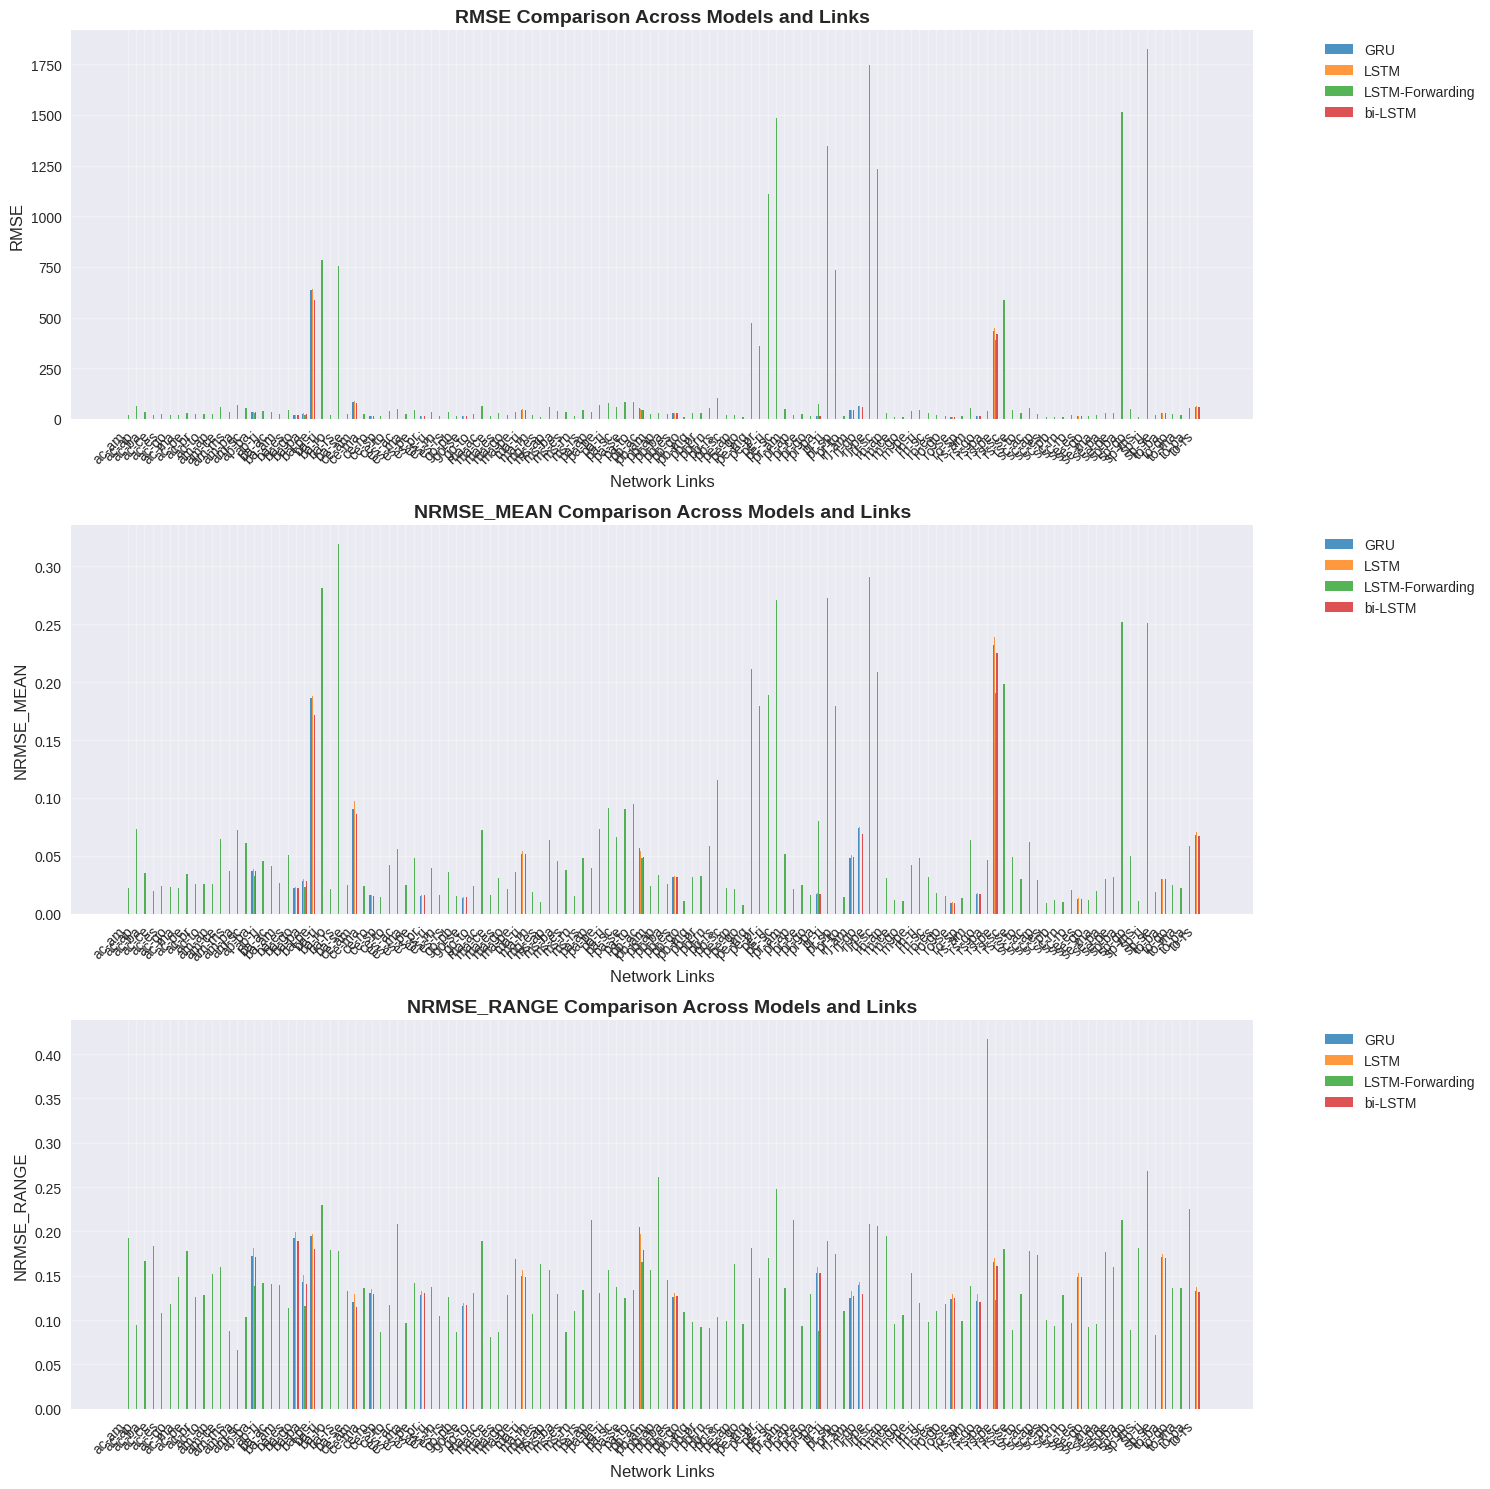

Creating heatmap comparison...


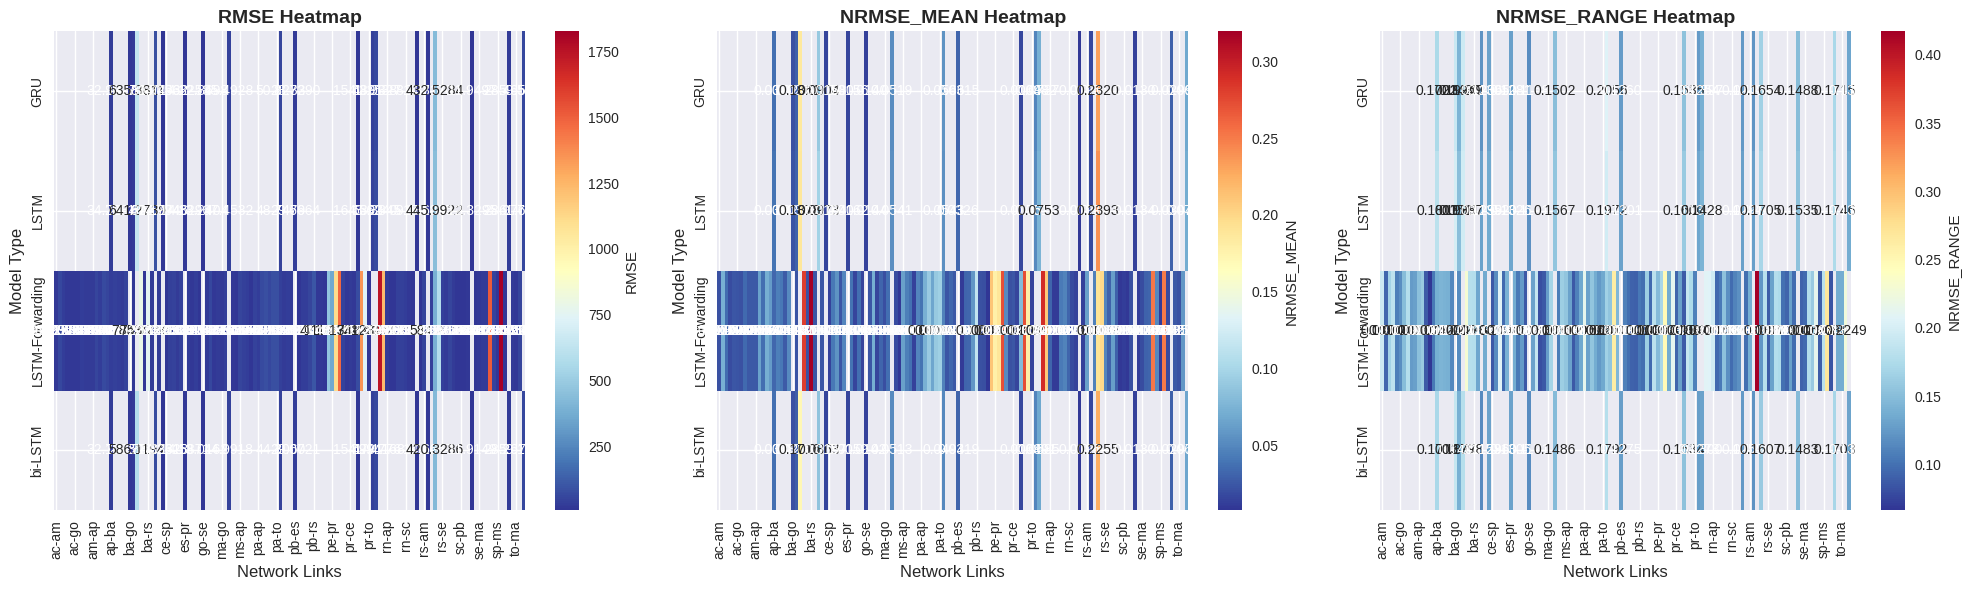

Creating best model summary...


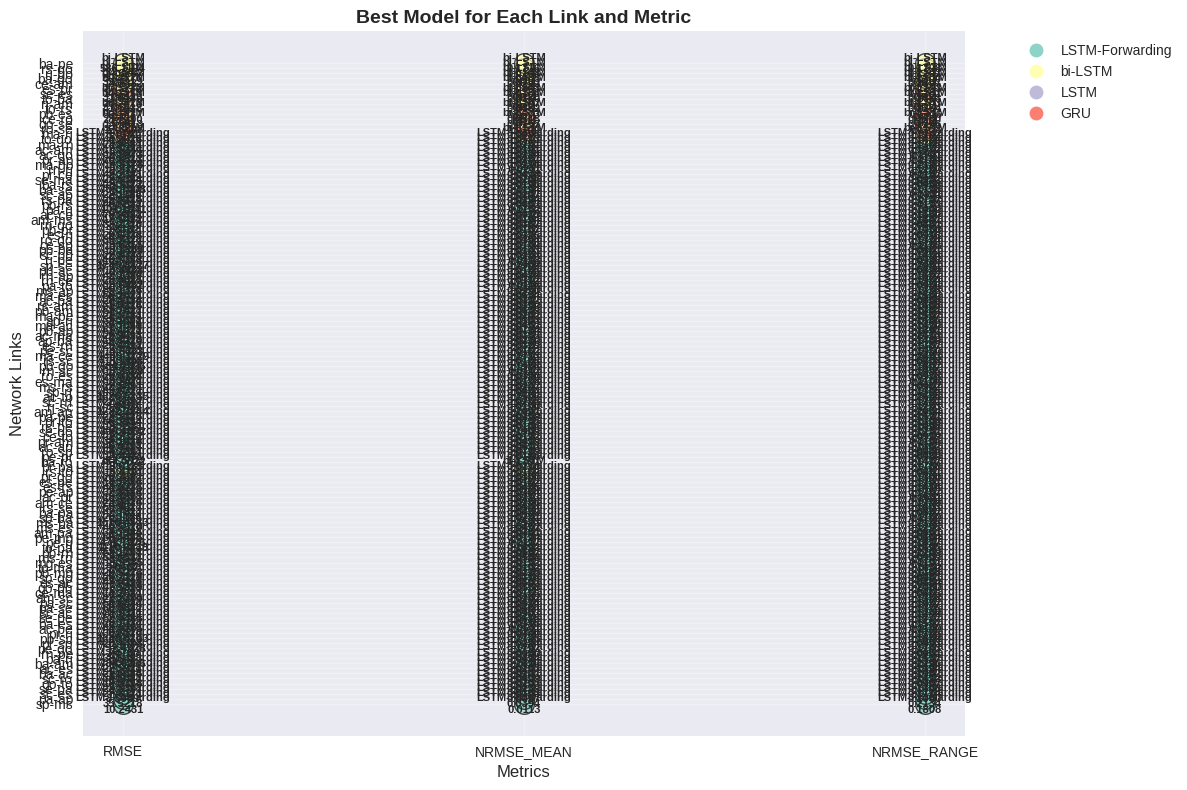

Generating performance ranking...

OVERALL MODEL PERFORMANCE RANKING
(Lower scores are better)

1. bi-LSTM
   RMSE: 78.007804
   NRMSE_MEAN: 0.051003
   NRMSE_RANGE: 0.144840
   Overall Score: 0.094144

2. GRU
   RMSE: 81.841320
   NRMSE_MEAN: 0.052908
   NRMSE_RANGE: 0.148081
   Overall Score: 0.276465

3. LSTM
   RMSE: 83.871157
   NRMSE_MEAN: 0.054556
   NRMSE_RANGE: 0.152963
   Overall Score: 0.489667

4. LSTM-Forwarding
   RMSE: 153.664079
   NRMSE_MEAN: 0.060078
   NRMSE_RANGE: 0.141643
   Overall Score: 0.666667


SUMMARY STATISTICS
                  rmse                                               \
                 count        mean         std       min        25%   
model                                                                 
GRU               20.0   81.841320  159.330138  8.733144  14.651057   
LSTM              20.0   83.871157  161.742114  9.081153  15.510789   
LSTM-Forwarding  114.0  153.664079  369.998265  7.475972  19.487256   
bi-LSTM           20.0   78.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

class LSTMResultsComparator:
    def __init__(self, new_approach_csv, legacy_csv):
        """
        Initialize the comparator with paths to the CSV files
        
        Args:
            new_approach_csv: Path to CSV with new LSTM forwarding approach results
            legacy_csv: Path to CSV with legacy model results (bi-LSTM, LSTM, GRU)
        """
        self.new_approach_csv = new_approach_csv
        self.legacy_csv = legacy_csv
        self.metrics = ['rmse', 'nrmse_mean', 'nrmse_range']
        
    def extract_link_from_filename(self, filename):
        """
        Extract network link information from filename
        
        Args:
            filename: String containing the filename
            
        Returns:
            String with the network link (e.g., 'sp-ms', 'ba-ce')
        """
        # For new approach files: treated_bbr_esmond_data_sp_ms_07_07_2023_predictions.csv
        new_pattern = r'treated_bbr_esmond_data_([a-z]{2}_[a-z]{2})_\d{2}_\d{2}_\d{4}'
        new_match = re.search(new_pattern, filename)
        if new_match:
            return new_match.group(1).replace('_', '-')
        
        # For legacy files: prediction bi-LSTM interpolacao-linear - treated bbr esmond data ma-rj 07-03-2023_longest_interval.csv.csv
        legacy_pattern = r'treated bbr esmond data ([a-z]{2}-[a-z]{2}) \d{2}-\d{2}-\d{4}'
        legacy_match = re.search(legacy_pattern, filename)
        if legacy_match:
            return legacy_match.group(1)
        
        return None
    
    def extract_model_from_filename(self, filename):
        """
        Extract model type from filename
        
        Args:
            filename: String containing the filename
            
        Returns:
            String with the model type
        """
        if 'prediction bi-LSTM' in filename:
            return 'bi-LSTM'
        elif 'prediction LSTM' in filename:
            return 'LSTM'
        elif 'prediction GRU' in filename:
            return 'GRU'
        elif 'treated_bbr_esmond_data' in filename and 'predictions' in filename:
            return 'LSTM-Forwarding'
        else:
            return 'Unknown'
    
    def load_and_process_data(self):
        """
        Load and process both CSV files
        
        Returns:
            DataFrame with processed results
        """
        # Load new approach data
        try:
            new_data = pd.read_csv(self.new_approach_csv)
        except Exception as e:
            print(f"Error loading new approach CSV: {e}")
            return None
        
        # Load legacy data
        try:
            legacy_data = pd.read_csv(self.legacy_csv)
        except Exception as e:
            print(f"Error loading legacy CSV: {e}")
            return None
        
        # Process new approach data
        new_results = []
        for _, row in new_data.iterrows():
            filename = row.get('filename', '')
            link = self.extract_link_from_filename(filename)
            model = self.extract_model_from_filename(filename)
            
            if link:
                result = {
                    'link': link,
                    'model': model,
                    'filename': filename
                }
                for metric in self.metrics:
                    result[metric] = row.get(metric, np.nan)
                new_results.append(result)
        
        # Process legacy data
        legacy_results = []
        for _, row in legacy_data.iterrows():
            filename = row.get('filename', '')
            link = self.extract_link_from_filename(filename)
            model = self.extract_model_from_filename(filename)
            
            if link:
                result = {
                    'link': link,
                    'model': model,
                    'filename': filename
                }
                for metric in self.metrics:
                    result[metric] = row.get(metric, np.nan)
                legacy_results.append(result)
        
        # Combine results
        all_results = new_results + legacy_results
        df = pd.DataFrame(all_results)
        
        # Remove rows with missing data
        df = df.dropna(subset=self.metrics)
        
        return df
    
    def create_comparison_plots(self, df):
        """
        Create comparison plots for all metrics
        
        Args:
            df: DataFrame with processed results
        """
        # Set style
        plt.style.use('seaborn-v0_8')
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        
        # Get unique links
        links = sorted(df['link'].unique())
        
        # Create subplots for each metric
        fig, axes = plt.subplots(len(self.metrics), 1, figsize=(15, 5*len(self.metrics)))
        if len(self.metrics) == 1:
            axes = [axes]
        
        for idx, metric in enumerate(self.metrics):
            ax = axes[idx]
            
            # Prepare data for plotting
            models = sorted(df['model'].unique())
            x_pos = np.arange(len(links))
            width = 0.15
            
            for i, model in enumerate(models):
                model_data = df[df['model'] == model]
                values = []
                
                for link in links:
                    link_data = model_data[model_data['link'] == link]
                    if not link_data.empty:
                        values.append(link_data[metric].iloc[0])
                    else:
                        values.append(0)
                
                ax.bar(x_pos + i*width, values, width, label=model, 
                      color=colors[i % len(colors)], alpha=0.8)
            
            ax.set_xlabel('Network Links', fontsize=12)
            ax.set_ylabel(metric.upper(), fontsize=12)
            ax.set_title(f'{metric.upper()} Comparison Across Models and Links', fontsize=14, fontweight='bold')
            ax.set_xticks(x_pos + width * (len(models)-1)/2)
            ax.set_xticklabels(links, rotation=45, ha='right')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('lstm_comparison_metrics.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_heatmap_comparison(self, df):
        """
        Create heatmap comparison for each metric
        
        Args:
            df: DataFrame with processed results
        """
        fig, axes = plt.subplots(1, len(self.metrics), figsize=(20, 6))
        if len(self.metrics) == 1:
            axes = [axes]
        
        for idx, metric in enumerate(self.metrics):
            # Pivot data for heatmap
            pivot_data = df.pivot_table(values=metric, index='model', columns='link', 
                                       aggfunc='first', fill_value=np.nan)
            
            # Create heatmap
            sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='RdYlBu_r', 
                       ax=axes[idx], cbar_kws={'label': metric.upper()})
            axes[idx].set_title(f'{metric.upper()} Heatmap', fontsize=14, fontweight='bold')
            axes[idx].set_xlabel('Network Links', fontsize=12)
            axes[idx].set_ylabel('Model Type', fontsize=12)
        
        plt.tight_layout()
        plt.savefig('lstm_comparison_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_best_model_summary(self, df):
        """
        Create summary showing best model for each link and metric
        
        Args:
            df: DataFrame with processed results
        """
        best_models = {}
        
        for link in df['link'].unique():
            link_data = df[df['link'] == link]
            best_models[link] = {}
            
            for metric in self.metrics:
                # For error metrics, lower is better
                best_idx = link_data[metric].idxmin()
                best_model = link_data.loc[best_idx, 'model']
                best_value = link_data.loc[best_idx, metric]
                best_models[link][metric] = (best_model, best_value)
        
        # Create summary plot
        fig, ax = plt.subplots(figsize=(12, 8))
        
        links = list(best_models.keys())
        models = df['model'].unique()
        model_colors = {model: plt.cm.Set3(i) for i, model in enumerate(models)}
        
        # Create a grid to show best models
        y_pos = np.arange(len(links))
        
        for i, metric in enumerate(self.metrics):
            for j, link in enumerate(links):
                best_model, best_value = best_models[link][metric]
                color = model_colors[best_model]
                
                ax.scatter(i, j, c=[color], s=200, alpha=0.7, edgecolors='black', linewidth=1)
                ax.text(i, j, f'{best_model}\n{best_value:.4f}', 
                       ha='center', va='center', fontsize=8, fontweight='bold')
        
        ax.set_xticks(range(len(self.metrics)))
        ax.set_xticklabels([m.upper() for m in self.metrics])
        ax.set_yticks(range(len(links)))
        ax.set_yticklabels(links)
        ax.set_xlabel('Metrics', fontsize=12)
        ax.set_ylabel('Network Links', fontsize=12)
        ax.set_title('Best Model for Each Link and Metric', fontsize=14, fontweight='bold')
        
        # Add legend
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color, markersize=10, label=model)
                          for model, color in model_colors.items()]
        ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('lstm_best_models_summary.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return best_models
    
    def generate_performance_ranking(self, df):
        """
        Generate overall performance ranking
        
        Args:
            df: DataFrame with processed results
        """
        # Calculate average performance across all links for each model
        model_performance = df.groupby('model')[self.metrics].mean()
        
        # Calculate overall score (weighted average of normalized metrics)
        # Normalize metrics to 0-1 scale (lower is better for all metrics)
        normalized_metrics = model_performance.copy()
        for metric in self.metrics:
            min_val = model_performance[metric].min()
            max_val = model_performance[metric].max()
            normalized_metrics[metric] = (model_performance[metric] - min_val) / (max_val - min_val)
        
        # Calculate overall score (equal weights)
        normalized_metrics['overall_score'] = normalized_metrics[self.metrics].mean(axis=1)
        
        # Sort by overall score (lower is better)
        ranking = normalized_metrics.sort_values('overall_score')
        
        print("\n" + "="*50)
        print("OVERALL MODEL PERFORMANCE RANKING")
        print("="*50)
        print("(Lower scores are better)")
        print()
        
        for i, (model, scores) in enumerate(ranking.iterrows(), 1):
            print(f"{i}. {model}")
            for metric in self.metrics:
                print(f"   {metric.upper()}: {model_performance.loc[model, metric]:.6f}")
            print(f"   Overall Score: {scores['overall_score']:.6f}")
            print()
        
        return ranking
    
    def run_analysis(self):
        """
        Run the complete analysis
        """
        print("Loading and processing data...")
        df = self.load_and_process_data()
        
        if df is None or df.empty:
            print("Error: No data could be processed. Please check your CSV files.")
            return
        
        print(f"Successfully processed {len(df)} results")
        print(f"Links found: {', '.join(sorted(df['link'].unique()))}")
        print(f"Models found: {', '.join(sorted(df['model'].unique()))}")
        
        print("\nCreating comparison plots...")
        self.create_comparison_plots(df)
        
        print("Creating heatmap comparison...")
        self.create_heatmap_comparison(df)
        
        print("Creating best model summary...")
        best_models = self.create_best_model_summary(df)
        
        print("Generating performance ranking...")
        ranking = self.generate_performance_ranking(df)
        
        return df, best_models, ranking

# Example usage
if __name__ == "__main__":
    # Initialize the comparator
    comparator = LSTMResultsComparator(
        new_approach_csv="metrics_summary.csv",
        legacy_csv="metrics_summary2_cleaned.csv"
    )
    
    # Run the analysis
    results_df, best_models, ranking = comparator.run_analysis()
    
    # Display summary statistics
    if results_df is not None:
        print("\n" + "="*50)
        print("SUMMARY STATISTICS")
        print("="*50)
        print(results_df.groupby('model')[['rmse', 'nrmse_mean', 'nrmse_range']].describe())

Loading and processing data...
Links found in new approach: ['ac-am', 'ac-ap', 'ac-ba', 'ac-ce', 'ac-es', 'ac-go', 'ac-ma', 'ac-pe', 'ac-pr', 'ac-to', 'am-ap', 'am-ce', 'am-ms', 'am-pa', 'am-sc', 'ap-ba', 'ap-rj', 'ba-ac', 'ba-am', 'ba-es', 'ba-pa', 'ba-rj', 'ba-ro', 'ba-rs', 'ba-se', 'ce-ma', 'ce-sp', 'ce-to', 'es-ac', 'es-ma', 'es-pe', 'es-rj', 'es-rn', 'es-rs', 'go-pb', 'go-to', 'ma-ac', 'ma-ce', 'ma-es', 'ma-go', 'ma-pe', 'ma-rn', 'mg-es', 'ms-ap', 'ms-ba', 'ms-es', 'ms-rn', 'ms-rs', 'pa-ap', 'pa-pe', 'pa-rj', 'pa-sc', 'pa-se', 'pa-to', 'pb-ac', 'pb-am', 'pb-ap', 'pb-ba', 'pb-go', 'pb-mg', 'pb-pr', 'pb-rn', 'pb-rs', 'pb-sc', 'pe-ap', 'pe-go', 'pe-mg', 'pe-pr', 'pe-rj', 'pe-sc', 'pr-am', 'pr-ap', 'pr-ce', 'pr-go', 'pr-pa', 'pr-rj', 'pr-sp', 'pr-to', 'rj-pe', 'rj-sc', 'rn-ap', 'rn-ce', 'rn-go', 'rn-pe', 'rn-rj', 'rn-sc', 'ro-es', 'ro-go', 'ro-sp', 'rs-am', 'rs-pa', 'rs-pe', 'rs-sc', 'rs-se', 'rs-to', 'sc-ac', 'sc-ap', 'sc-es', 'sc-pb', 'sc-rn', 'sc-ro', 'se-go', 'se-ma', 'se-pa', 'se

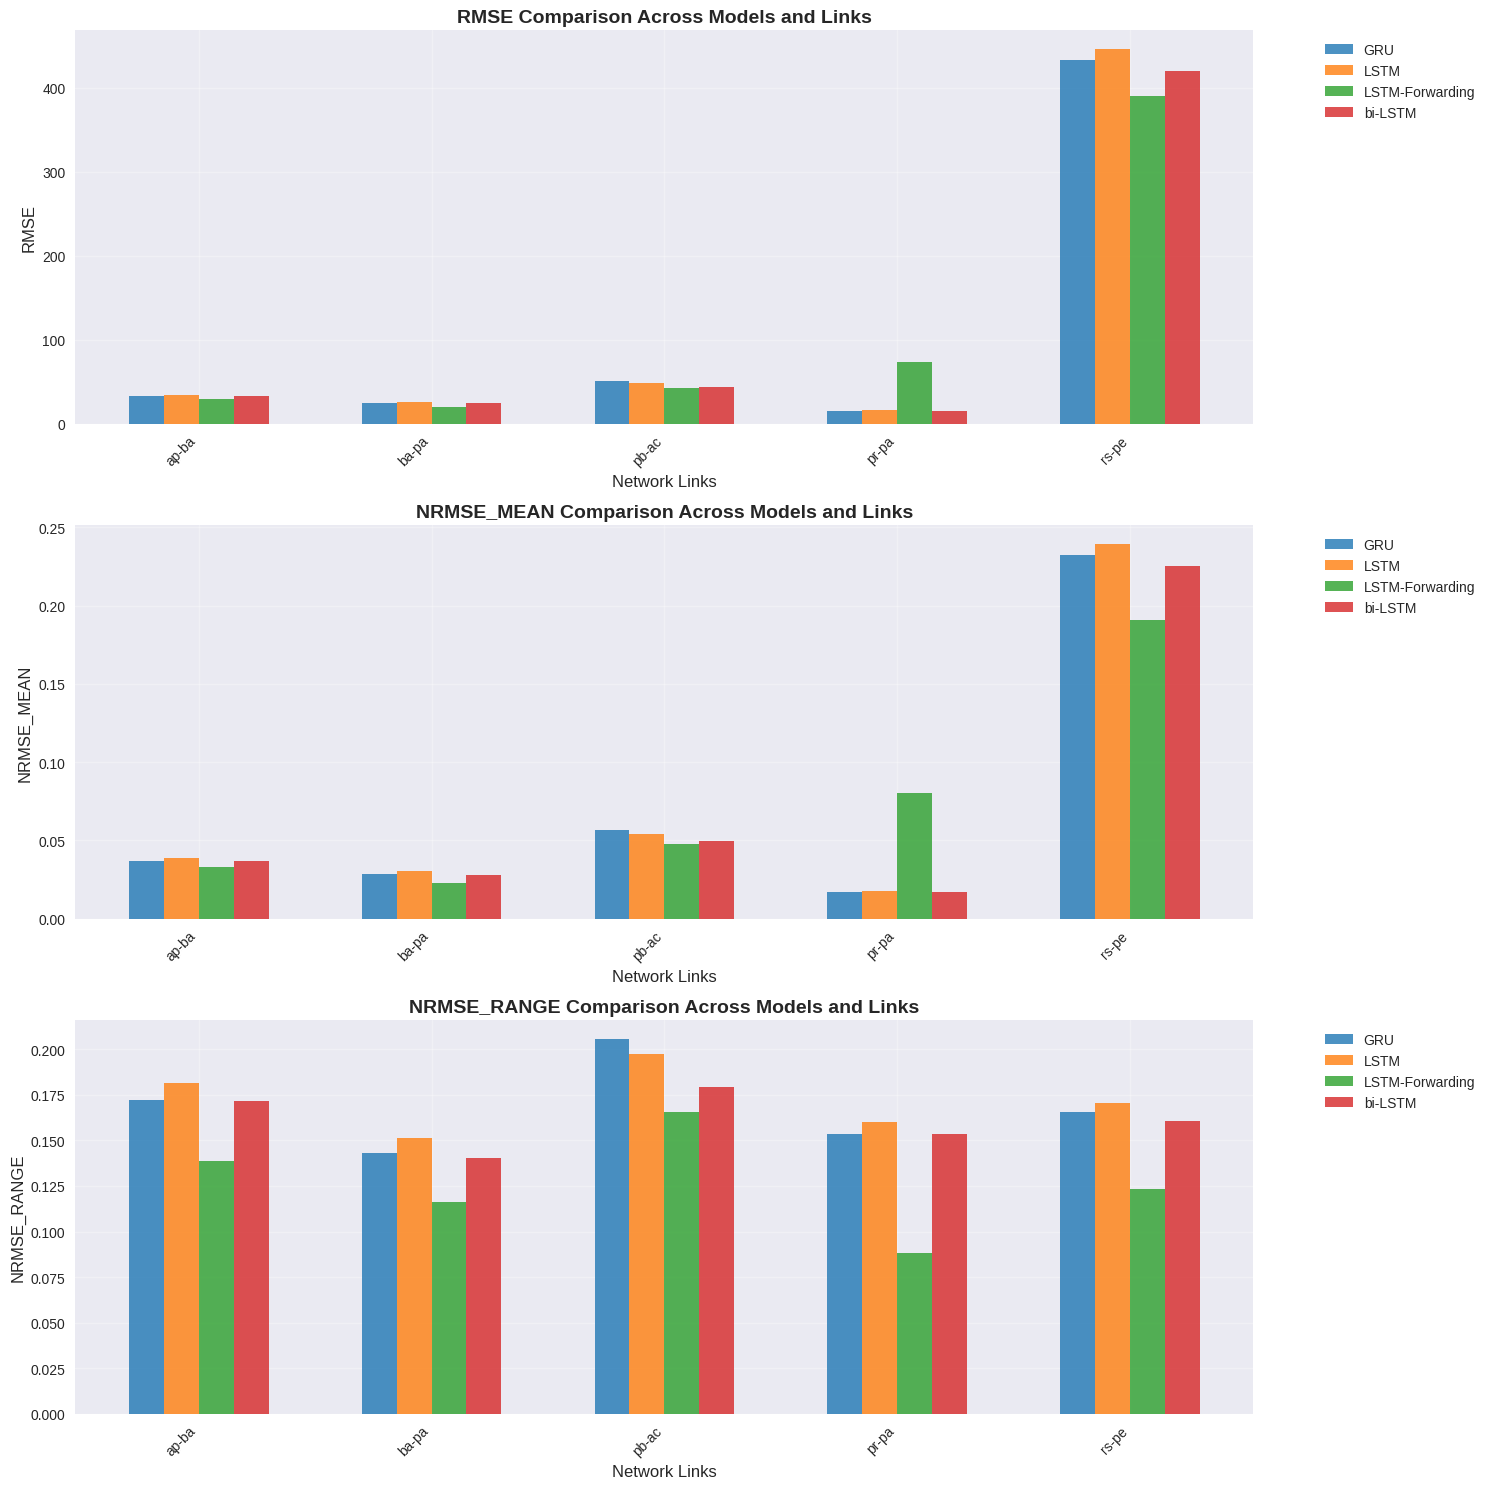

Creating heatmap comparison...


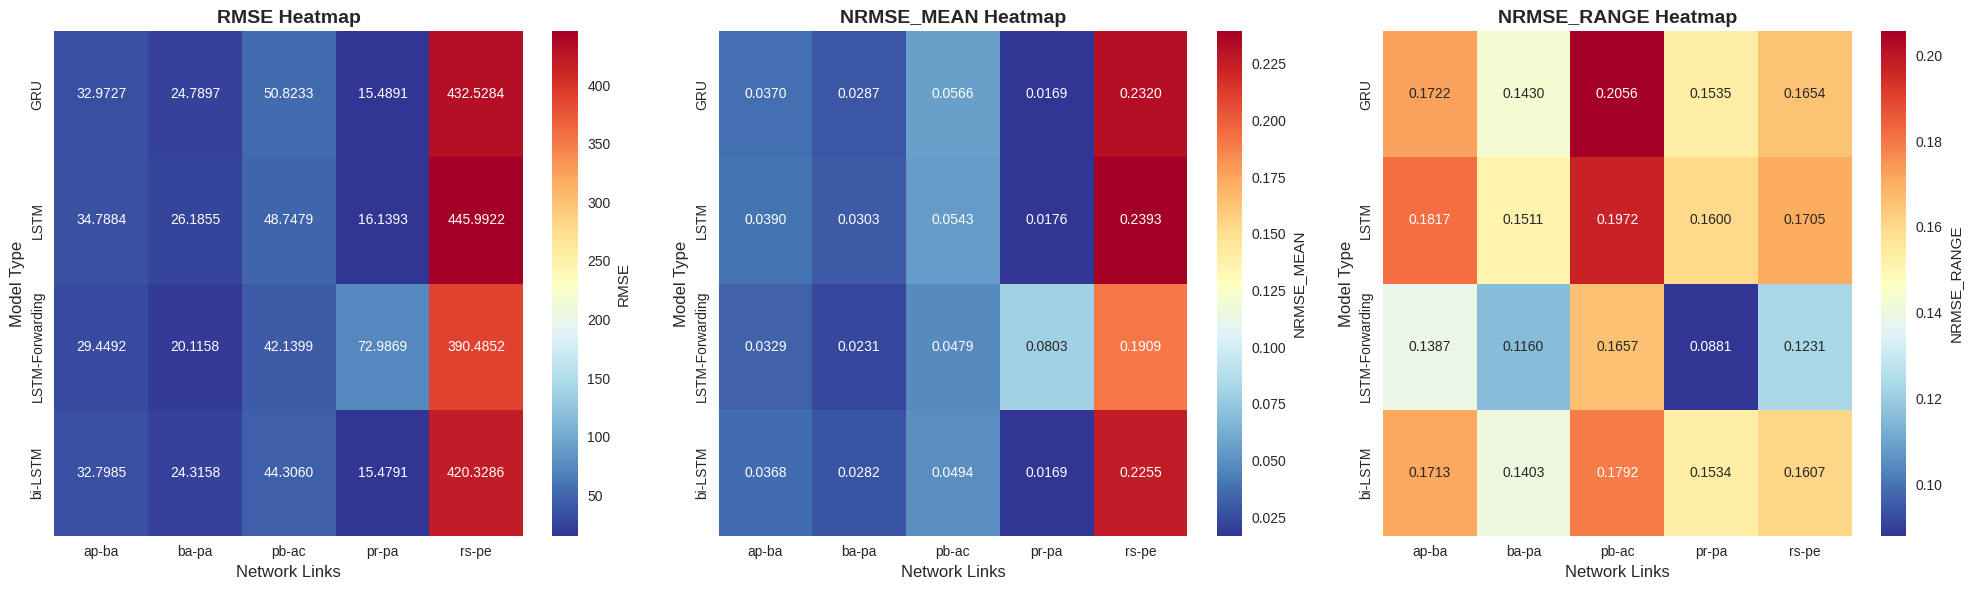

Creating best model summary...


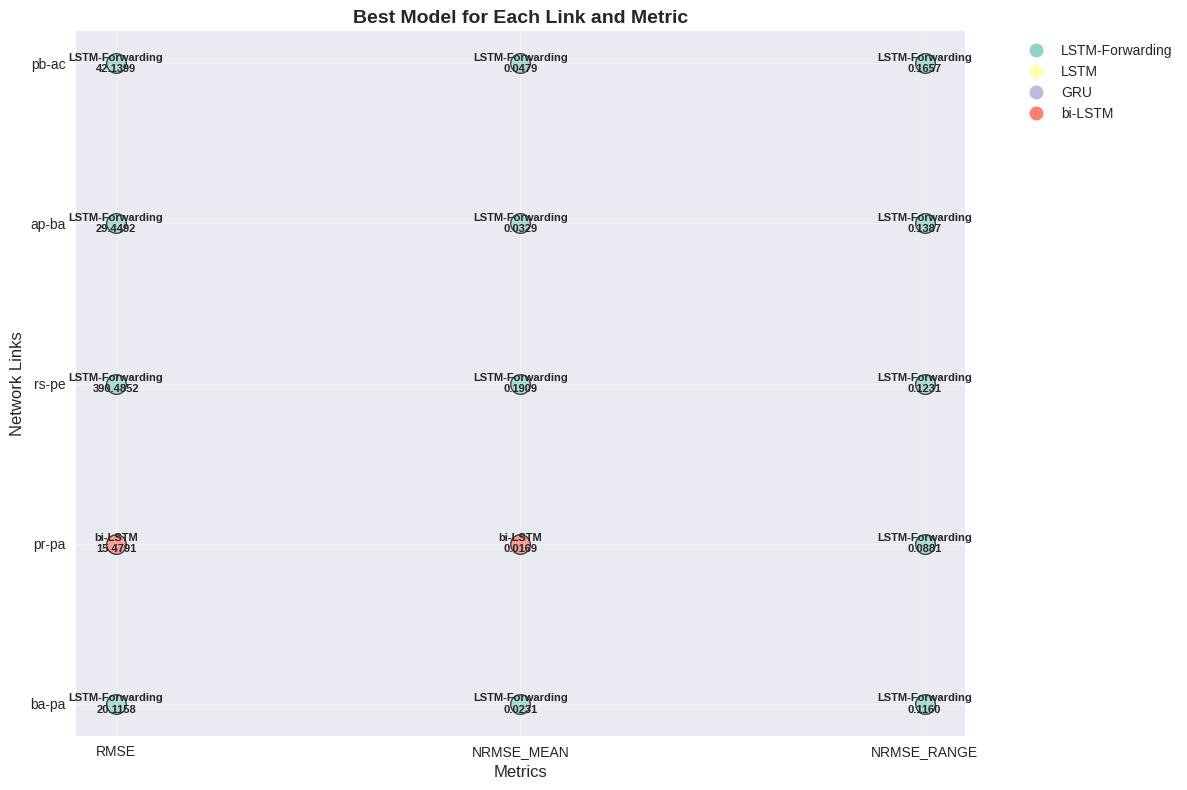

Generating performance ranking...

OVERALL MODEL PERFORMANCE RANKING
(Lower scores are better)

1. LSTM-Forwarding
   RMSE: 97.470903
   NRMSE_MEAN: 0.068054
   NRMSE_RANGE: 0.128529
   Overall Score: 0.000000

2. bi-LSTM
   RMSE: 107.445574
   NRMSE_MEAN: 0.071354
   NRMSE_RANGE: 0.160983
   Overall Score: 0.581478

3. GRU
   RMSE: 111.320636
   NRMSE_MEAN: 0.074266
   NRMSE_RANGE: 0.167937
   Overall Score: 0.831456

4. LSTM
   RMSE: 114.370649
   NRMSE_MEAN: 0.076122
   NRMSE_RANGE: 0.172083
   Overall Score: 1.000000


SUMMARY STATISTICS
                 rmse                                                \
                count        mean         std        min        25%   
model                                                                 
GRU               5.0  111.320636  180.030566  15.489144  24.789653   
LSTM              5.0  114.370649  185.767708  16.139269  26.185473   
LSTM-Forwarding   6.0   97.470903  144.726633  20.115790  29.498998   
bi-LSTM           5.0  107

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

class LSTMResultsComparator:
    def __init__(self, new_approach_csv, legacy_csv):
        """
        Initialize the comparator with paths to the CSV files
        
        Args:
            new_approach_csv: Path to CSV with new LSTM forwarding approach results
            legacy_csv: Path to CSV with legacy model results (bi-LSTM, LSTM, GRU)
        """
        self.new_approach_csv = new_approach_csv
        self.legacy_csv = legacy_csv
        self.metrics = ['rmse', 'nrmse_mean', 'nrmse_range']
        
    def extract_link_from_filename(self, filename):
        """
        Extract network link information from filename
        
        Args:
            filename: String containing the filename
            
        Returns:
            String with the network link (e.g., 'sp-ms', 'ba-ce')
        """
        # For new approach files: treated_bbr_esmond_data_sp_ms_07_07_2023_predictions.csv
        new_pattern = r'treated_bbr_esmond_data_([a-z]{2}_[a-z]{2})_\d{2}_\d{2}_\d{4}'
        new_match = re.search(new_pattern, filename)
        if new_match:
            return new_match.group(1).replace('_', '-')
        
        # For legacy files: prediction bi-LSTM interpolacao-linear - treated bbr esmond data ma-rj 07-03-2023_longest_interval.csv.csv
        legacy_pattern = r'treated bbr esmond data ([a-z]{2}-[a-z]{2}) \d{2}-\d{2}-\d{4}'
        legacy_match = re.search(legacy_pattern, filename)
        if legacy_match:
            return legacy_match.group(1)
        
        return None
    
    def extract_model_from_filename(self, filename):
        """
        Extract model type from filename
        
        Args:
            filename: String containing the filename
            
        Returns:
            String with the model type
        """
        if 'prediction bi-LSTM' in filename:
            return 'bi-LSTM'
        elif 'prediction LSTM' in filename:
            return 'LSTM'
        elif 'prediction GRU' in filename:
            return 'GRU'
        elif 'treated_bbr_esmond_data' in filename and 'predictions' in filename:
            return 'LSTM-Forwarding'
        else:
            return 'Unknown'
    
    def load_and_process_data(self):
        """
        Load and process both CSV files
        
        Returns:
            DataFrame with processed results
        """
        # Load new approach data
        try:
            new_data = pd.read_csv(self.new_approach_csv)
        except Exception as e:
            print(f"Error loading new approach CSV: {e}")
            return None
        
        # Load legacy data
        try:
            legacy_data = pd.read_csv(self.legacy_csv)
        except Exception as e:
            print(f"Error loading legacy CSV: {e}")
            return None
        
        # Process new approach data
        new_results = []
        new_links = set()
        for _, row in new_data.iterrows():
            filename = row.get('filename', '')
            link = self.extract_link_from_filename(filename)
            model = self.extract_model_from_filename(filename)
            
            if link:
                new_links.add(link)
                result = {
                    'link': link,
                    'model': model,
                    'filename': filename
                }
                for metric in self.metrics:
                    result[metric] = row.get(metric, np.nan)
                new_results.append(result)
        
        # Process legacy data
        legacy_results = []
        legacy_links = set()
        for _, row in legacy_data.iterrows():
            filename = row.get('filename', '')
            link = self.extract_link_from_filename(filename)
            model = self.extract_model_from_filename(filename)
            
            if link:
                legacy_links.add(link)
                result = {
                    'link': link,
                    'model': model,
                    'filename': filename
                }
                for metric in self.metrics:
                    result[metric] = row.get(metric, np.nan)
                legacy_results.append(result)
        
        # Find common links between both datasets
        common_links = new_links.intersection(legacy_links)
        
        print(f"Links found in new approach: {sorted(new_links)}")
        print(f"Links found in legacy approach: {sorted(legacy_links)}")
        print(f"Common links to be included in analysis: {sorted(common_links)}")
        
        if not common_links:
            print("Warning: No common links found between the two datasets!")
            return None
        
        # Filter results to only include common links
        filtered_new_results = [r for r in new_results if r['link'] in common_links]
        filtered_legacy_results = [r for r in legacy_results if r['link'] in common_links]
        
        # Combine results
        all_results = filtered_new_results + filtered_legacy_results
        df = pd.DataFrame(all_results)
        
        # Remove rows with missing data
        df = df.dropna(subset=self.metrics)
        
        return df
    
    def create_comparison_plots(self, df):
        """
        Create comparison plots for all metrics
        
        Args:
            df: DataFrame with processed results
        """
        # Set style
        plt.style.use('seaborn-v0_8')
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        
        # Get unique links
        links = sorted(df['link'].unique())
        
        # Create subplots for each metric
        fig, axes = plt.subplots(len(self.metrics), 1, figsize=(15, 5*len(self.metrics)))
        if len(self.metrics) == 1:
            axes = [axes]
        
        for idx, metric in enumerate(self.metrics):
            ax = axes[idx]
            
            # Prepare data for plotting
            models = sorted(df['model'].unique())
            x_pos = np.arange(len(links))
            width = 0.15
            
            for i, model in enumerate(models):
                model_data = df[df['model'] == model]
                values = []
                
                for link in links:
                    link_data = model_data[model_data['link'] == link]
                    if not link_data.empty:
                        values.append(link_data[metric].iloc[0])
                    else:
                        values.append(0)
                
                ax.bar(x_pos + i*width, values, width, label=model, 
                      color=colors[i % len(colors)], alpha=0.8)
            
            ax.set_xlabel('Network Links', fontsize=12)
            ax.set_ylabel(metric.upper(), fontsize=12)
            ax.set_title(f'{metric.upper()} Comparison Across Models and Links', fontsize=14, fontweight='bold')
            ax.set_xticks(x_pos + width * (len(models)-1)/2)
            ax.set_xticklabels(links, rotation=45, ha='right')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('lstm_comparison_metrics.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_heatmap_comparison(self, df):
        """
        Create heatmap comparison for each metric
        
        Args:
            df: DataFrame with processed results
        """
        fig, axes = plt.subplots(1, len(self.metrics), figsize=(20, 6))
        if len(self.metrics) == 1:
            axes = [axes]
        
        for idx, metric in enumerate(self.metrics):
            # Pivot data for heatmap
            pivot_data = df.pivot_table(values=metric, index='model', columns='link', 
                                       aggfunc='first', fill_value=np.nan)
            
            # Create heatmap
            sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='RdYlBu_r', 
                       ax=axes[idx], cbar_kws={'label': metric.upper()})
            axes[idx].set_title(f'{metric.upper()} Heatmap', fontsize=14, fontweight='bold')
            axes[idx].set_xlabel('Network Links', fontsize=12)
            axes[idx].set_ylabel('Model Type', fontsize=12)
        
        plt.tight_layout()
        plt.savefig('lstm_comparison_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_best_model_summary(self, df):
        """
        Create summary showing best model for each link and metric
        
        Args:
            df: DataFrame with processed results
        """
        best_models = {}
        
        for link in df['link'].unique():
            link_data = df[df['link'] == link]
            best_models[link] = {}
            
            for metric in self.metrics:
                # For error metrics, lower is better
                best_idx = link_data[metric].idxmin()
                best_model = link_data.loc[best_idx, 'model']
                best_value = link_data.loc[best_idx, metric]
                best_models[link][metric] = (best_model, best_value)
        
        # Create summary plot
        fig, ax = plt.subplots(figsize=(12, 8))
        
        links = list(best_models.keys())
        models = df['model'].unique()
        model_colors = {model: plt.cm.Set3(i) for i, model in enumerate(models)}
        
        # Create a grid to show best models
        y_pos = np.arange(len(links))
        
        for i, metric in enumerate(self.metrics):
            for j, link in enumerate(links):
                best_model, best_value = best_models[link][metric]
                color = model_colors[best_model]
                
                ax.scatter(i, j, c=[color], s=200, alpha=0.7, edgecolors='black', linewidth=1)
                ax.text(i, j, f'{best_model}\n{best_value:.4f}', 
                       ha='center', va='center', fontsize=8, fontweight='bold')
        
        ax.set_xticks(range(len(self.metrics)))
        ax.set_xticklabels([m.upper() for m in self.metrics])
        ax.set_yticks(range(len(links)))
        ax.set_yticklabels(links)
        ax.set_xlabel('Metrics', fontsize=12)
        ax.set_ylabel('Network Links', fontsize=12)
        ax.set_title('Best Model for Each Link and Metric', fontsize=14, fontweight='bold')
        
        # Add legend
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color, markersize=10, label=model)
                          for model, color in model_colors.items()]
        ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('lstm_best_models_summary.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return best_models
    
    def generate_performance_ranking(self, df):
        """
        Generate overall performance ranking
        
        Args:
            df: DataFrame with processed results
        """
        # Calculate average performance across all links for each model
        model_performance = df.groupby('model')[self.metrics].mean()
        
        # Calculate overall score (weighted average of normalized metrics)
        # Normalize metrics to 0-1 scale (lower is better for all metrics)
        normalized_metrics = model_performance.copy()
        for metric in self.metrics:
            min_val = model_performance[metric].min()
            max_val = model_performance[metric].max()
            normalized_metrics[metric] = (model_performance[metric] - min_val) / (max_val - min_val)
        
        # Calculate overall score (equal weights)
        normalized_metrics['overall_score'] = normalized_metrics[self.metrics].mean(axis=1)
        
        # Sort by overall score (lower is better)
        ranking = normalized_metrics.sort_values('overall_score')
        
        print("\n" + "="*50)
        print("OVERALL MODEL PERFORMANCE RANKING")
        print("="*50)
        print("(Lower scores are better)")
        print()
        
        for i, (model, scores) in enumerate(ranking.iterrows(), 1):
            print(f"{i}. {model}")
            for metric in self.metrics:
                print(f"   {metric.upper()}: {model_performance.loc[model, metric]:.6f}")
            print(f"   Overall Score: {scores['overall_score']:.6f}")
            print()
        
        return ranking
    
    def run_analysis(self):
        """
        Run the complete analysis
        """
        print("Loading and processing data...")
        df = self.load_and_process_data()
        
        if df is None or df.empty:
            print("Error: No data could be processed. Please check your CSV files.")
            return
        
        print(f"Successfully processed {len(df)} results")
        print(f"Links found: {', '.join(sorted(df['link'].unique()))}")
        print(f"Models found: {', '.join(sorted(df['model'].unique()))}")
        
        print("\nCreating comparison plots...")
        self.create_comparison_plots(df)
        
        print("Creating heatmap comparison...")
        self.create_heatmap_comparison(df)
        
        print("Creating best model summary...")
        best_models = self.create_best_model_summary(df)
        
        print("Generating performance ranking...")
        ranking = self.generate_performance_ranking(df)
        
        return df, best_models, ranking

# Example usage
if __name__ == "__main__":
    # Initialize the comparator
    comparator = LSTMResultsComparator(
        new_approach_csv="metrics_summary.csv",
        legacy_csv="metrics_summary2_cleaned.csv"
    )
    
    # Run the analysis
    results_df, best_models, ranking = comparator.run_analysis()
    
    # Display summary statistics
    if results_df is not None:
        print("\n" + "="*50)
        print("SUMMARY STATISTICS")
        print("="*50)
        print(results_df.groupby('model')[['rmse', 'nrmse_mean', 'nrmse_range']].describe())